In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Load QM9 CSV
df = pd.read_csv("qm9_.csv")

# Subset the data for quick testing
subset_size = 1000  # You can change this to 1000, 10000, etc.       133883 size of full dataset
df = df.dropna(subset=["homo", "lumo", "gap", "alpha"]).sample(n=subset_size, random_state=42).reset_index(drop=True)

# Extract SMILES and targets
target_columns = ["homo", "lumo", "gap", "alpha"]
smiles_list = df["smiles"].tolist()
target_props = df[target_columns].values

# Normalize targets
scaler = StandardScaler()
target_props = scaler.fit_transform(target_props)

# Train/test split
train_smiles, test_smiles, train_y, test_y = train_test_split(smiles_list, target_props, test_size=0.2, random_state=42)



In [3]:
class SMILESTokenizer:
    def __init__(self):
        self.special = ['<pad>', '<bos>', '<eos>', '<unk>']
        self.vocab = {tok: idx for idx, tok in enumerate(self.special)}

    def tokenize(self, smiles):
        return list(smiles)

    def build_vocab(self, smiles_list):
        chars = set(c for smi in smiles_list for c in self.tokenize(smi))
        for c in sorted(chars):
            if c not in self.vocab:
                self.vocab[c] = len(self.vocab)

        self.inv_vocab = {v: k for k, v in self.vocab.items()}

    def encode(self, smiles, max_len=128):
        tokens = self.tokenize(smiles)
        ids = [self.vocab.get(tok, self.vocab['<unk>']) for tok in tokens]
        ids = [self.vocab['<bos>']] + ids[:max_len-2] + [self.vocab['<eos>']]
        ids += [self.vocab['<pad>']] * (max_len - len(ids))
        return torch.tensor(ids)

    def vocab_size(self):
        return len(self.vocab)

tokenizer = SMILESTokenizer()
tokenizer.build_vocab(train_smiles + test_smiles)

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch

class QM9Dataset(Dataset):
    def __init__(self, smiles, targets, tokenizer):
        self.smiles = smiles
        self.targets = targets
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = self.tokenizer.encode(self.smiles[idx])
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y

train_dataset = QM9Dataset(train_smiles, train_y, tokenizer)
test_dataset = QM9Dataset(test_smiles, test_y, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [5]:
import torch.nn as nn

class TransformerRegressor(nn.Module):
    def __init__(self, vocab_size, seq_len, dim=256, heads=16, depth=6, ff_mult=2, n_outputs=4):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, 8)
        self.pos_embed = nn.Parameter(torch.randn(1, seq_len, 8))
        self.proj = nn.Linear(8, dim)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=ff_mult*dim, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.head = nn.Sequential(
            nn.Linear(dim, dim // 2),
            nn.ReLU(),
            nn.Linear(dim // 2, n_outputs)
        )

    def forward(self, x):
        x = self.embed(x) + self.pos_embed[:, :x.size(1), :]
        x = self.proj(x)
        x = self.encoder(x)
        x = x.mean(dim=1)  # average pooling
        return self.head(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(tokenizer.vocab_size(), seq_len=128).to(device)

In [7]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.MSELoss()

num_epochs = 5
train_losses = []
test_losses = []

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation phase
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for x, y in tqdm(test_loader, desc=f"Epoch {epoch+1} [Test]"):
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)




# for epoch in range(3):
#     model.train()
#     total_loss = 0
#     for x, y in tqdm(train_loader):
#         x, y = x.to(device), y.to(device)
#         pred = model(x)
#         loss = loss_fn(pred, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()

#     print(f"Epoch {epoch+1} | Loss: {total_loss / len(train_loader):.4f}")

Epoch 5 [Test]: 100%|██████████| 4/4 [00:00<00:00,  6.42it/s]


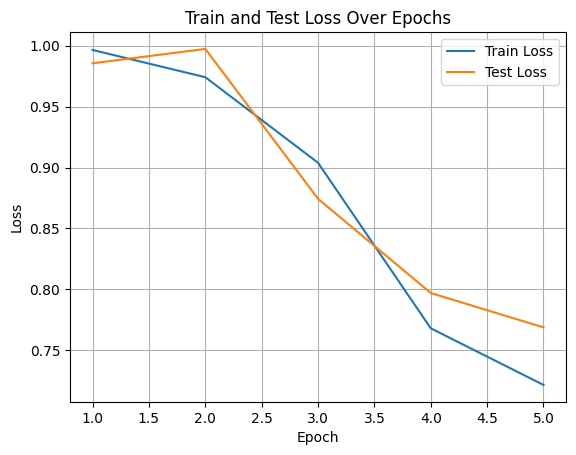

In [8]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Test Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

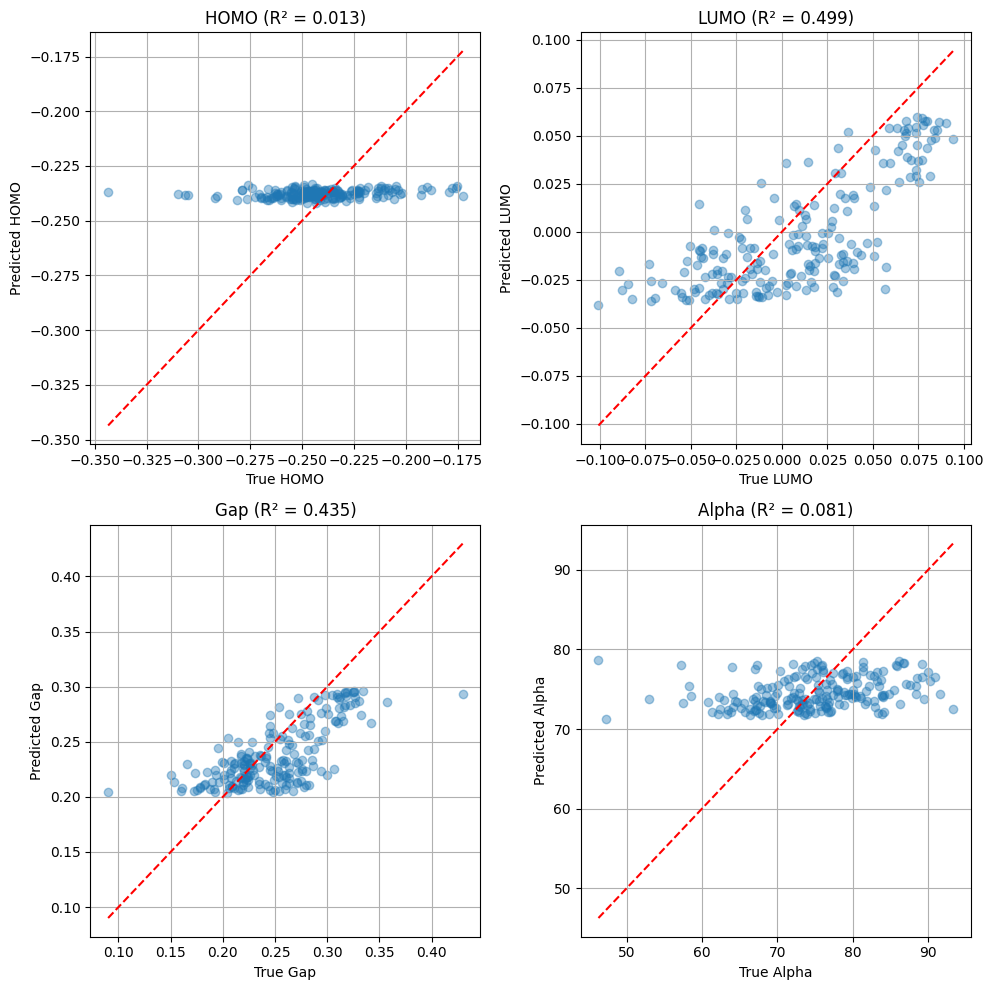

In [9]:
from sklearn.metrics import r2_score

model.eval()
preds, truths = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x)
        preds.append(pred.cpu())
        truths.append(y)

preds = torch.cat(preds).numpy()
truths = torch.cat(truths).numpy()

# Inverse transform targets
preds = scaler.inverse_transform(preds)
truths = scaler.inverse_transform(truths)

# Plot setup
labels = ["HOMO", "LUMO", "Gap", "Alpha"]
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()

for i in range(4):
    r2 = r2_score(truths[:, i], preds[:, i])
    axs[i].scatter(truths[:, i], preds[:, i], alpha=0.4)
    axs[i].plot([truths[:, i].min(), truths[:, i].max()],
                [truths[:, i].min(), truths[:, i].max()], 'r--')
    axs[i].set_xlabel(f"True {labels[i]}")
    axs[i].set_ylabel(f"Predicted {labels[i]}")
    axs[i].set_title(f"{labels[i]} (R² = {r2:.3f})")
    axs[i].grid(True)

plt.tight_layout()
plt.show()

Autoregressive Transformer

In [85]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
RDKIT_AVAILABLE = True

In [108]:
# --- Configuration ---
# Model Parameters (as specified by user)
D_MODEL = 256  # Channels
N_HEADS = 8
D_FF = 1024  # Feedforward Multiplier 4 -> 256 * 4 = 1024
SMILES_EMBEDDING_DIM = 16 # Embedding Dimension for SMILES tokens
# CROSS_ATTENTION_EMBEDDING_DIM = 8 # Not directly used as k/v dim for simplicity, see notes.
MAX_SEQ_LEN = 128  # Maximum SMILES sequence length
DECODER_DEPTH = 6  # Number of decoder layers
PROPERTY_DIM = 4  # homo, lumo, gap, alpha
DROPOUT = 0.1

# Training Parameters (example values)
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
NUM_EPOCHS = 3 # Placeholder: actual training needs more
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Special Tokens
PAD_TOKEN = "<pad>"
SOS_TOKEN = "<sos>" # Start of Sequence
EOS_TOKEN = "<eos>" # End of Sequence
UNK_TOKEN = "<unk>" # Unknown token

In [109]:
# --- SMILES Tokenizer ---
class SMILESTokenizer:
    def __init__(self):
        self.special_tokens = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]
        self.char_to_idx = {}
        self.idx_to_char = {}
        self.vocab_size = 0

    def fit(self, smiles_list):
        # Gathers all unique characters from SMILES strings
        all_chars = set()
        for smiles in smiles_list:
            for char in smiles:
                all_chars.add(char)
        
        # Sort characters for consistent mapping
        sorted_chars = sorted(list(all_chars))
        
        # Initialize with special tokens
        self.char_to_idx = {token: i for i, token in enumerate(self.special_tokens)}
        current_idx = len(self.special_tokens)
        
        # Add unique SMILES characters
        for char in sorted_chars:
            if char not in self.char_to_idx: # Should not happen if special tokens are not in SMILES chars
                self.char_to_idx[char] = current_idx
                current_idx += 1
        
        self.idx_to_char = {i: char for char, i in self.char_to_idx.items()}
        self.vocab_size = len(self.char_to_idx)
        
        # Ensure special tokens have correct indices
        self.pad_idx = self.char_to_idx[PAD_TOKEN]
        self.sos_idx = self.char_to_idx[SOS_TOKEN]
        self.eos_idx = self.char_to_idx[EOS_TOKEN]
        self.unk_idx = self.char_to_idx[UNK_TOKEN]

    def tokenize(self, smiles_string):
        # Converts a SMILES string to a list of token IDs
        return [self.char_to_idx.get(char, self.unk_idx) for char in smiles_string]

    def detokenize(self, token_ids):
        # Converts a list of token IDs back to a SMILES string
        chars = []
        for token_id in token_ids:
            if token_id == self.eos_idx:
                break
            if token_id not in [self.sos_idx, self.pad_idx]: # Don't include SOS or PAD in output string
                 chars.append(self.idx_to_char.get(token_id, UNK_TOKEN))
        return "".join(chars)


In [110]:

# --- Positional Encoding ---
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=MAX_SEQ_LEN):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0) # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe) # Not a model parameter

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        # self.pe shape: (1, max_len, d_model)
        # We need to select the relevant part of pe: self.pe[:, :x.size(1), :]
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)


In [111]:
# --- Transformer Model ---
class SmilesTransformer(nn.Module):
    def __init__(self, vocab_size, property_dim, d_model, n_heads, d_ff,
                 decoder_depth, smiles_embedding_dim, max_seq_len, dropout, pad_idx): # Added pad_idx
        super(SmilesTransformer, self).__init__()
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.property_projector = nn.Linear(property_dim, d_model)
        self.smiles_embedder = nn.Embedding(vocab_size, smiles_embedding_dim, padding_idx=pad_idx) # Use passed pad_idx
        self.smiles_input_projector = nn.Linear(smiles_embedding_dim, d_model)
        self.positional_encoder = PositionalEncoding(d_model, dropout, max_seq_len)

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, activation='relu', batch_first=True, norm_first=True
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=decoder_depth)
        self.output_layer = nn.Linear(d_model, vocab_size)

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask.to(DEVICE)

    def forward(self, properties, tgt_smiles_tokens, tgt_padding_mask=None):
        memory = self.property_projector(properties).unsqueeze(1) 
        tgt_embed = self.smiles_embedder(tgt_smiles_tokens)
        tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
        tgt_pos_encoded = self.positional_encoder(tgt_projected)
        tgt_mask = self._generate_square_subsequent_mask(tgt_smiles_tokens.size(1))
        decoder_output = self.transformer_decoder(
            tgt=tgt_pos_encoded, memory=memory,
            tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask
        )
        return self.output_layer(decoder_output)

    def generate(self, properties, tokenizer, max_len=MAX_SEQ_LEN):
        self.eval()
        if properties.ndim == 1:
            properties = properties.unsqueeze(0)
        properties = properties.to(DEVICE)
        generated_ids = torch.tensor([[tokenizer.sos_idx]], dtype=torch.long, device=DEVICE)
        memory = self.property_projector(properties).unsqueeze(1)

        with torch.no_grad():
            for _ in range(max_len - 1):
                tgt_embed = self.smiles_embedder(generated_ids)
                tgt_projected = self.smiles_input_projector(tgt_embed) * math.sqrt(self.d_model)
                tgt_pos_encoded = self.positional_encoder(tgt_projected)
                tgt_mask = self._generate_square_subsequent_mask(generated_ids.size(1))
                decoder_output = self.transformer_decoder(tgt=tgt_pos_encoded, memory=memory, tgt_mask=tgt_mask)
                last_token_logits = self.output_layer(decoder_output[:, -1, :])
                predicted_id = torch.argmax(last_token_logits, dim=-1).unsqueeze(1)
                generated_ids = torch.cat([generated_ids, predicted_id], dim=1)
                if predicted_id.item() == tokenizer.eos_idx:
                    break
        return tokenizer.detokenize(generated_ids.squeeze(0).cpu().tolist())


In [112]:
# --- Dataset and DataLoader ---
class QM9Dataset(Dataset):
    def __init__(self, properties_df, smiles_list, tokenizer, max_seq_len):
        self.properties = torch.tensor(properties_df.values, dtype=torch.float)
        self.smiles_list = smiles_list
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len

    def __len__(self):
        return len(self.smiles_list)

    def __getitem__(self, idx):
        props = self.properties[idx]
        smiles = self.smiles_list[idx]

        # Tokenize SMILES: <sos> + tokens + <eos>
        tokenized_smiles = [self.tokenizer.sos_idx] + self.tokenizer.tokenize(smiles) + [self.tokenizer.eos_idx]
        
        # Pad or truncate
        if len(tokenized_smiles) < self.max_seq_len:
            padding = [self.tokenizer.pad_idx] * (self.max_seq_len - len(tokenized_smiles))
            tokenized_smiles.extend(padding)
        else:
            tokenized_smiles = tokenized_smiles[:self.max_seq_len -1] + [self.tokenizer.eos_idx] # Ensure EOS if truncated

        # Input to decoder: <sos> t1 t2 ... tn-1 <pad> ...
        # Target for loss:   t1 t2 ... tn-1 <eos> <pad> ...
        # Both should have length max_seq_len
        
        # Decoder input sequence (starts with SOS, ends before final EOS if full, or with PADs)
        # Example: if tokenized_smiles = [sos, t1, t2, eos, pad, pad] (len 6, max_len 6)
        # input_seq = [sos, t1, t2, eos, pad] (remove last, for predicting next)
        # target_seq = [t1, t2, eos, pad, pad] (remove first)

        input_seq = torch.tensor(tokenized_smiles[:-1], dtype=torch.long)
        target_seq = torch.tensor(tokenized_smiles[1:], dtype=torch.long) # Shifted right

        # Create padding mask for the input sequence (True where it's a pad token)
        # This is for tgt_key_padding_mask in TransformerDecoder
        padding_mask = (input_seq == self.tokenizer.pad_idx)

        return props, input_seq, target_seq, padding_mask


In [113]:
# --- Generation and Evaluation ---
def generate_new_sequences(model, tokenizer, scaler, target_properties_unscaled_list, qm9_smiles_set, property_names):
    """
    Generates SMILES sequences for given target properties, checks against QM9,
    and visualizes them.
    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        target_properties_unscaled_list (list of dicts): List of dictionaries, 
            each with unscaled property values (e.g., {'homo': -7.0, 'lumo': -1.0, 'gap': 6.0, 'alpha': 75.0}).
            Must contain 'gap' and 'alpha'. Other properties will be used if present, otherwise
            defaults might be needed or an error raised if not all 4 are present.
        qm9_smiles_set (set): A set of SMILES strings from the QM9 dataset for quick lookup.
        property_names (list): List of property names in the order expected by the scaler and model.
    Returns:
        list of dicts: Each dict contains 'target_properties_unscaled', 
                       'target_properties_scaled', 'generated_smiles', 
                       'is_in_qm9', 'is_valid_rdkit', 'mol_image_path'.
    """
    generated_results = []
    output_dir = "generated_molecules"
    os.makedirs(output_dir, exist_ok=True)

    for i, props_unscaled_dict in enumerate(target_properties_unscaled_list):
        print(f"\nGenerating for target (unscaled): {props_unscaled_dict}")

        # Ensure all required properties are present and in correct order for scaling
        current_props_unscaled = np.array([props_unscaled_dict.get(p_name, 0) for p_name in property_names])
        
        # Scale the properties
        props_scaled = scaler.transform(current_props_unscaled.reshape(1, -1))
        props_tensor = torch.tensor(props_scaled.squeeze(), dtype=torch.float).to(DEVICE)

        # Generate SMILES
        smiles_gen = model.generate(props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        is_in_qm9 = smiles_gen in qm9_smiles_set
        is_valid_rdkit = False
        mol_image_path = None

        if RDKIT_AVAILABLE and smiles_gen:
            mol = Chem.MolFromSmiles(smiles_gen)
            if mol:
                is_valid_rdkit = True
                try:
                    img = MolsToGridImage([mol], molsPerRow=1, subImgSize=(200,200))
                    mol_image_path = os.path.join(output_dir, f"generated_{i+1}.png")
                    # MolsToGridImage returns a PIL image. To save it:
                    # For this, you might need PIL (Pillow) if not already a dep of rdkit/matplotlib
                    # from PIL import Image (handled by MolsToGridImage if it creates an image object)
                    # For simplicity, let's assume MolsToGridImage can save or we use a simpler Draw.MolToImage
                    from rdkit.Chem.Draw import MolToFile
                    MolToFile(mol, mol_image_path, size=(300,300))
                    print(f"Visualized and saved to: {mol_image_path}")
                except Exception as e:
                    print(f"Error visualizing SMILES '{smiles_gen}': {e}")
                    mol_image_path = None # Reset on error
            else:
                print(f"Generated SMILES '{smiles_gen}' is not valid according to RDKit.")
        
        result = {
            'target_properties_unscaled': props_unscaled_dict,
            'target_properties_scaled': props_scaled.squeeze().tolist(),
            'generated_smiles': smiles_gen,
            'is_in_qm9': is_in_qm9,
            'is_valid_rdkit': is_valid_rdkit,
            'mol_image_path': mol_image_path
        }
        generated_results.append(result)

        print(f"Generated SMILES: {smiles_gen}")
        print(f"Is in QM9: {is_in_qm9}")
        print(f"RDKit valid: {is_valid_rdkit}")
        
    return generated_results

def plot_target_property_performance(generated_results, property_x='gap', property_y='alpha'):
    """
    Plots the target properties (e.g., gap vs alpha) for the generated sequences.
    Args:
        generated_results (list of dicts): Output from generate_new_sequences.
        property_x (str): Name of the property for the x-axis.
        property_y (str): Name of the property for the y-axis.
    """
    if not generated_results:
        print("No results to plot.")
        return

    x_values = [res['target_properties_unscaled'][property_x] for res in generated_results]
    y_values = [res['target_properties_unscaled'][property_y] for res in generated_results]
    
    plt.figure(figsize=(8, 6))
    plt.scatter(x_values, y_values, c='blue', alpha=0.7, label='Target Properties for Generation')
    plt.xlabel(f"Target {property_x.capitalize()} (unscaled)")
    plt.ylabel(f"Target {property_y.capitalize()} (unscaled)")
    plt.title(f"Target Performance of Generated Molecules ({property_y.capitalize()} vs {property_x.capitalize()})")
    plt.legend()
    plt.grid(True)
    plot_filename = "target_properties_plot.png"
    plt.savefig(plot_filename)
    print(f"Target properties plot saved to {plot_filename}")
    # plt.show() # Uncomment if running in an environment that supports interactive plots

In [114]:
try:
    df_full = pd.read_csv("qm9_.csv")
    print(f"Successfully loaded qm9_.csv. Shape: {df_full.shape}")
except FileNotFoundError:
    print("Error: qm9_.csv not found. Please ensure the file is in the correct directory.")

# Drop rows with NaNs in specified property columns
property_cols = ["homo", "lumo", "gap", "alpha"]
df_full = df_full.dropna(subset=property_cols)
print(f"Shape after dropping NaNs: {df_full.shape}")

if df_full.empty:
    print("DataFrame is empty after dropping NaNs. Cannot proceed.")
    exit()

# Create a set of existing SMILES for quick lookup
qm9_smiles_set = set(df_full['smiles'].tolist())

Successfully loaded qm9_.csv. Shape: (133885, 13)
Shape after dropping NaNs: (133885, 13)


In [ ]:
# Filter for "high performing" molecules (e.g., top 25% in gap and alpha)
# You might want to adjust these quantiles
percentile = 0.95 # make 0.75 when ready to train
gap_threshold = df_full['gap'].quantile(percentile)
alpha_threshold = df_full['alpha'].quantile(percentile)

df_filtered = df_full[
    (df_full['gap'] >= gap_threshold) & \
    (df_full['alpha'] >= alpha_threshold)
].copy() # Use .copy() to avoid SettingWithCopyWarning
print(f"Shape after filtering for high gap/alpha: {df_filtered.shape}")

if df_filtered.empty:
    print("DataFrame is empty after filtering for high gap/alpha. Try adjusting thresholds or check data.")
    exit()

Shape after filtering for high gap/alpha: (13142, 13)


In [116]:
# Normalize properties (using only filtered data for scaler fitting)
scaler = StandardScaler()
df_filtered.loc[:, property_cols] = scaler.fit_transform(df_filtered[property_cols])

# Extract properties and SMILES
properties_data = df_filtered[property_cols]
smiles_data = df_filtered['smiles'].tolist()

# 2. Initialize Tokenizer and Fit on SMILES data
tokenizer = SMILESTokenizer()
tokenizer.fit(smiles_data) # Fit on the actual SMILES strings from the dataset
print(f"Tokenizer vocabulary size: {tokenizer.vocab_size}")
print(f"PAD index: {tokenizer.pad_idx}, SOS index: {tokenizer.sos_idx}, EOS index: {tokenizer.eos_idx}")


# 3. Create Dataset and DataLoader
qm9_dataset = QM9Dataset(properties_data, smiles_data, tokenizer, MAX_SEQ_LEN)
# Note: For actual training, split into train/validation sets
# For simplicity, using the whole filtered dataset here
data_loader = DataLoader(qm9_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0) # num_workers=0 for simplicity


Tokenizer vocabulary size: 16
PAD index: 0, SOS index: 1, EOS index: 2


In [117]:
# 4. Initialize Model, Optimizer, Loss
model = SmilesTransformer(
    vocab_size=tokenizer.vocab_size,
    property_dim=PROPERTY_DIM,
    d_model=D_MODEL,
    n_heads=N_HEADS,
    d_ff=D_FF,
    decoder_depth=DECODER_DEPTH,
    smiles_embedding_dim=SMILES_EMBEDDING_DIM,
    max_seq_len=MAX_SEQ_LEN,
    dropout=DROPOUT,
    pad_idx=tokenizer.pad_idx # Pass pad_idx explicitly
).to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Use CrossEntropyLoss, ignore padding index in loss calculation
criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_idx)

print(f"Model initialized on {DEVICE}. Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# 5. Training Loop (Simplified Outline)
print(f"\n--- Starting Simplified Training Loop (for {NUM_EPOCHS} epochs) ---")
model.train() # Set model to training mode
for epoch in range(NUM_EPOCHS):
    epoch_loss = 0
    for batch_idx, (props, input_seqs, target_seqs, padding_masks) in enumerate(data_loader):
        props = props.to(DEVICE)
        input_seqs = input_seqs.to(DEVICE) # (batch, seq_len-1)
        target_seqs = target_seqs.to(DEVICE) # (batch, seq_len-1)
        padding_masks = padding_masks.to(DEVICE) # (batch, seq_len-1)

        optimizer.zero_grad()
        
        # output_logits shape: (batch_size, seq_len-1, vocab_size)
        output_logits = model(props, input_seqs, tgt_padding_mask=padding_masks)
        
        # Reshape for CrossEntropyLoss:
        # output_logits: (batch_size * (seq_len-1), vocab_size)
        # target_seqs: (batch_size * (seq_len-1))
        loss = criterion(output_logits.reshape(-1, tokenizer.vocab_size), target_seqs.reshape(-1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()

        if batch_idx % 5 == 0: # Print progress every 5 batches
                print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(data_loader)}], Loss: {loss.item():.4f}")


    avg_epoch_loss = epoch_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed. Average Loss: {avg_epoch_loss:.4f}")

print("--- Training Loop Finished (Simplified) ---")


Model initialized on cpu. Parameters: 6330640

--- Starting Simplified Training Loop (for 3 epochs) ---


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch [1/3], Batch [1/411], Loss: 8.1296
Epoch [1/3], Batch [6/411], Loss: 4.7264
Epoch [1/3], Batch [11/411], Loss: 3.3457
Epoch [1/3], Batch [16/411], Loss: 2.7805
Epoch [1/3], Batch [21/411], Loss: 2.7135
Epoch [1/3], Batch [26/411], Loss: 2.2167
Epoch [1/3], Batch [31/411], Loss: 2.2099
Epoch [1/3], Batch [36/411], Loss: 2.0538
Epoch [1/3], Batch [41/411], Loss: 1.9723
Epoch [1/3], Batch [46/411], Loss: 1.9973
Epoch [1/3], Batch [51/411], Loss: 1.8874
Epoch [1/3], Batch [56/411], Loss: 1.8258
Epoch [1/3], Batch [61/411], Loss: 1.7521
Epoch [1/3], Batch [66/411], Loss: 1.8200
Epoch [1/3], Batch [71/411], Loss: 1.7525
Epoch [1/3], Batch [76/411], Loss: 1.7543
Epoch [1/3], Batch [81/411], Loss: 1.7185
Epoch [1/3], Batch [86/411], Loss: 1.6122
Epoch [1/3], Batch [91/411], Loss: 1.7893
Epoch [1/3], Batch [96/411], Loss: 1.6563
Epoch [1/3], Batch [101/411], Loss: 1.6904
Epoch [1/3], Batch [106/411], Loss: 1.6546
Epoch [1/3], Batch [111/411], Loss: 1.5756
Epoch [1/3], Batch [116/411], Los

In [131]:
def compare_on_random_samples(model, tokenizer, scaler, full_dataset_df, 
                              property_column_names, num_samples=5):
    """
    Randomly samples from the full dataset, generates SMILES using the model,
    compares them to the original SMILES, and visualizes valid pairs,
    excluding pairs where either SMILES sequence is longer than 32 tokens.

    Args:
        model: The trained SmilesTransformer model.
        tokenizer: The SMILESTokenizer.
        scaler: The fitted StandardScaler for properties.
        full_dataset_df (pd.DataFrame): The complete qm9 dataframe (unscaled, unfiltered).
        property_column_names (list): List of property names in order for the scaler.
        num_samples (int): Number of random samples to evaluate.
    """
    print(f"\n--- Comparing Model Predictions on {num_samples} Random Samples from QM9 ---")
    
    if full_dataset_df.empty:
        print("Full dataset is empty, cannot sample.")
        return

    if num_samples > len(full_dataset_df):
        print(f"Requested {num_samples} samples, but dataset only has {len(full_dataset_df)}. Adjusting.")
        num_samples = len(full_dataset_df)

    required_cols_for_sampling = ['smiles'] + property_column_names
    # Ensure pandas (pd) is available, typically imported in the main script as 'pd'
    # Drop rows where any of these essential columns are NaN before sampling
    sample_df = full_dataset_df.dropna(subset=required_cols_for_sampling).sample(n=num_samples, random_state=42) # for reproducibility

    if sample_df.empty:
        print("No valid samples found after attempting to drop NaNs from required columns. Cannot proceed.")
        return

    valid_rdkit_pairs = [] # To store dicts of valid original/generated pairs

    for index, row in sample_df.iterrows():
        original_smiles = row['smiles']
        # Prepare properties as a DataFrame for the scaler to avoid UserWarning
        unscaled_props_numpy = row[property_column_names].values.astype(float).reshape(1, -1)
        unscaled_props_df = pd.DataFrame(unscaled_props_numpy, columns=property_column_names)
        
        try:
            # Scaler transform expects a DataFrame if fitted with one, or matching columns.
            # It returns a NumPy array.
            scaled_props_numpy = scaler.transform(unscaled_props_df) # Corrected: remove .values
        except Exception as e:
            print(f"Error scaling properties for sample {index} (SMILES: {original_smiles}): {e}")
            print(f"Unscaled properties: {unscaled_props_numpy}")
            continue

        # Ensure scaled_props_numpy is correctly shaped for torch.tensor
        # .squeeze() removes single-dimensional entries from the shape of an array.
        # scaler.transform returns a 2D array (e.g., (1, num_features)), squeeze makes it 1D.
        squeezed_props = scaled_props_numpy.squeeze()
        
        # Ensure the tensor is correctly formed.
        # If only one property, squeeze might make it 0-dim.
        if squeezed_props.ndim == 0: 
            scaled_props_tensor = torch.tensor([squeezed_props.item()], dtype=torch.float).to(DEVICE)
        elif squeezed_props.ndim == 1:
             scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)
        else: 
            # This case should ideally not be hit if squeeze works as expected on (1, N) input
            print(f"Warning: Unexpected shape for scaled_props_numpy after squeeze: {squeezed_props.shape}. Using as is.")
            scaled_props_tensor = torch.tensor(squeezed_props, dtype=torch.float).to(DEVICE)

        generated_smiles = model.generate(scaled_props_tensor, tokenizer, max_len=MAX_SEQ_LEN)
        
        print(f"\nSample {index}:")
        print(f"  Original Properties (Unscaled):")
        for i, p_name in enumerate(property_column_names):
            print(f"    {p_name}: {unscaled_props_numpy[0, i]:.4f}") # Use unscaled_props_numpy for printing
        print(f"  Original SMILES: {original_smiles}")
        print(f"  Generated SMILES: {generated_smiles}")

        original_mol_valid = False
        generated_mol_valid = False
        original_mol_rdkit = None
        generated_mol_rdkit = None

        if RDKIT_AVAILABLE: # Global flag indicating RDKit was imported
            if original_smiles:
                original_mol_rdkit = Chem.MolFromSmiles(original_smiles) # Chem from rdkit
                if original_mol_rdkit:
                    original_mol_valid = True
            
            if generated_smiles:
                generated_mol_rdkit = Chem.MolFromSmiles(generated_smiles)
                if generated_mol_rdkit:
                    generated_mol_valid = True
                    print(f"  Generated SMILES is RDKit Valid: Yes")
                    if original_mol_valid: # Only store if original is also valid for comparison
                         valid_rdkit_pairs.append({
                             "original_smiles": original_smiles,
                             "generated_smiles": generated_smiles,
                             "original_mol": original_mol_rdkit,
                             "generated_mol": generated_mol_rdkit,
                             "id": index
                         })
                else:
                    print(f"  Generated SMILES is RDKit Valid: No (RDKit could not parse)")
            elif not generated_smiles:
                print(f"  Generated SMILES is Empty.")
        else:
            print("  RDKIT not available. Skipping SMILES validation and graphical output.")

    # After the loop, print all valid (original, generated) SMILES pairs
    if RDKIT_AVAILABLE and valid_rdkit_pairs:
        print("\n\n--- Valid RDKit-Generated SMILES Pairs (Original vs. Generated) ---")
        # This loop remains to print all valid pairs regardless of length for textual output
        for pair_info in valid_rdkit_pairs:
            print(f"Sample ID: {pair_info['id']}")
            print(f"  Original:  {pair_info['original_smiles']}")
            print(f"  Generated: {pair_info['generated_smiles']}")

        print("\n\n--- Graphical Comparison of Valid Original vs. Generated Sequences (<= 32 tokens) ---")
        
        mols_to_draw = []
        legends = []
        max_token_len_for_display = 32

        for pair_info in valid_rdkit_pairs:
            # Tokenize original and generated SMILES to check their length
            # The tokenizer.tokenize() method returns a list of token IDs.
            # We add SOS and EOS tokens for a more accurate length, similar to training.
            # However, for simple length check, just tokenizing the string itself is usually sufficient.
            # Let's use the raw tokenized length of the SMILES string itself.
            original_tokens = tokenizer.tokenize(pair_info['original_smiles'])
            generated_tokens = tokenizer.tokenize(pair_info['generated_smiles'])

            if len(original_tokens) <= max_token_len_for_display and \
               len(generated_tokens) <= max_token_len_for_display:
                mols_to_draw.append(pair_info['original_mol'])
                legends.append(f"Sample {pair_info['id']}\nOriginal ({len(original_tokens)} tok)")
                mols_to_draw.append(pair_info['generated_mol'])
                legends.append(f"Sample {pair_info['id']}\nGenerated ({len(generated_tokens)} tok)")
            else:
                print(f"Skipping Sample ID {pair_info['id']} from graphical display due to token length:")
                print(f"  Original SMILES: {pair_info['original_smiles']} (Tokens: {len(original_tokens)})")
                print(f"  Generated SMILES: {pair_info['generated_smiles']} (Tokens: {len(generated_tokens)})")


        if mols_to_draw:
            mols_per_row = 2 
            # MolsToGridImage from rdkit.Chem.Draw
            img = MolsToGridImage(mols_to_draw, molsPerRow=mols_per_row, subImgSize=(300,300), legends=legends)
            
            output_comparison_dir = "comparison_visualizations"
            os.makedirs(output_comparison_dir, exist_ok=True) # os from import os
            comparison_image_path = os.path.join(output_comparison_dir, "original_vs_generated_comparison_len_filtered.png") # New filename
            
            try:
                # Try standard PIL save first
                img.save(comparison_image_path)
                print(f"Graphical comparison (length filtered) saved to: {comparison_image_path}")
            except AttributeError: 
                # If .save attribute is missing, it might be an IPython Image or similar
                if hasattr(img, 'data') and isinstance(img.data, bytes):
                    print(f"Standard img.save() failed. Attempting to save image via .data attribute.")
                    try:
                        with open(comparison_image_path, 'wb') as f_img_data:
                            f_img_data.write(img.data)
                        print(f"Graphical comparison (length filtered) saved via .data to: {comparison_image_path}")
                    except Exception as e_data_write:
                        print(f"Error writing img.data to file: {e_data_write}")
                else:
                    print(f"Error: img.save() failed and img.data attribute is not available/bytes.")
                    print(f"Type of img object: {type(img)}. Cannot save image.")
            except Exception as e_general_save: # Catch other potential errors during save
                print(f"An unexpected error occurred while saving the image: {e_general_save}")
                print(f"Type of img object: {type(img)}")
        else:
            print("No RDKit-valid pairs (meeting token length criteria) to display graphically.")
            
    elif not RDKIT_AVAILABLE:
        print("\nSkipping graphical output as RDKit is not available.")
    elif not valid_rdkit_pairs: # RDKit available, but no valid pairs found
        print("\nRDKit is available, but no RDKit-valid generated SMILES (paired with valid originals) to display graphically.")



compare_on_random_samples(model, tokenizer, scaler, df_full, property_cols, num_samples=20)


--- Comparing Model Predictions on 20 Random Samples from QM9 ---


/Users/colinweaver/Documents/MIT Documents/2.174/NEMSTransformer/.venv copy/lib/python3.9/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


AttributeError: 'TransformerRegressor' object has no attribute 'generate'

In [132]:

# Number of sequences to generate
x = 100

# Get statistics from full dataset for generating random properties
homo_range = (df_full['homo'].min(), df_full['homo'].max())
lumo_range = (df_full['lumo'].min(), df_full['lumo'].max())
alpha_range = (df_full['alpha'].min(), df_full['alpha'].max())

# High-performing cutoffs (you already calculated these)
high_gap_target = df_full['gap'].quantile(0.95)
high_alpha_target = df_full['alpha'].quantile(0.95)

# 1. Generate random property sets
target_properties_list_unscaled = []

for _ in range(x):
    # 20% chance to sample from high-performing region
    if random.random() < 0.2:
        homo = random.uniform(-3.0, -1.5)
        lumo = random.uniform(2.0, 3.0)
        alpha = random.uniform(high_alpha_target, alpha_range[1])
    else:
        homo = random.uniform(*homo_range)
        lumo = random.uniform(*lumo_range)
        alpha = random.uniform(*alpha_range)

    # Ensure physical plausibility: LUMO > HOMO
    if lumo <= homo:
        lumo = homo + abs(np.random.normal(2.5, 0.5))  # Add positive gap

    gap = lumo - homo
    target_properties_list_unscaled.append({
        'homo': homo,
        'lumo': lumo,
        'gap': gap,
        'alpha': alpha
    })

# 2. Generate new sequences using the existing pipeline
generated_smiles_info = generate_new_sequences(
    model, 
    tokenizer, 
    scaler,
    target_properties_list_unscaled,
    qm9_smiles_set,
    property_cols
)

# 3. Filter valid sequences
valid_sequences = [
    info for info in generated_smiles_info 
    if info.get('valid', False)
]

# 4. Plot GAP vs. Alpha for valid sequences
gaps = [entry['target_properties']['gap'] for entry in valid_sequences]
alphas = [entry['target_properties']['alpha'] for entry in valid_sequences]

plt.figure(figsize=(8, 6))
plt.scatter(gaps, alphas, color='blue', label='Valid Sequences')

# Vertical lines for maximum values
plt.axvline(x=high_gap_target, color='red', linestyle='--', label='95th %ile GAP')
plt.axhline(y=high_alpha_target, color='green', linestyle='--', label='95th %ile Alpha')

plt.xlabel('Gap (eV)')
plt.ylabel('Alpha (Bohr^3)')
plt.title('Valid Generated Sequences: Gap vs. Alpha')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('target_properties_plot.png')
plt.show()



Generating for target (unscaled): {'homo': -1.6249525387312171, 'lumo': 2.1122850400105015, 'gap': 3.737237578741719, 'alpha': np.float64(185.20036957176404)}


AttributeError: 'TransformerRegressor' object has no attribute 'generate'